## Describe the business problem
An oil company manufactures different types of gasoline and diesel. Each type of gasoline is produced by blending different types of crude oils that must be purchased. The company must decide how much crude oil to buy in order to maximize its profit while respecting processing capacities and quality levels as well as satisfying customer demand.


The oil-blending problem consists of calculating different blends of gasoline according to specific quality criteria.

- Three types of gasoline are manufactured: super, regular, and diesel.

- Each type of gasoline is produced by blending three types of crude oil: crude1, crude2, and crude3.

- The gasoline must satisfy some quality criteria with respect to their lead content and their octane ratings, thus constraining the possible blendings.

- The company must also satisfy its customer demand, which is 3,000 barrels a day of super, 2,000 of regular, and 1,000 of diesel.

- The company can purchase 5,000 barrels of each type of crude oil per day and can process at most 14,000 barrels a day.

- In addition, the company has the option of advertising a gasoline, in which case the demand for this type of gasoline increases by ten barrels for every dollar spent.

- Finally, it costs four dollars to transform a barrel of oil into a barrel of gasoline.

### Use decision optimization

#### Step 1: Model the data
- For each type of crude oil, there are capacities of what can be bought, the buying price, the octane level, and the lead level.
- For each type of gasoline or diesel, there is customer demand, selling prices, and octane and lead levels.
- There is a maximum level of production imposed by the factory's limit as well as a fixed production cost.
- There are inventory costs for each type of final product and blending proportions. All of these have actual values in the model.

- The marginal production cost and maximum production are assumed to be identical for all oil types.

First we create a Numpy arrays for each gasoline and crude oil type with dimesion as shown : __(capacity, price, octane and lead level)__

In [30]:
import numpy as np
import pandas as pd

gas_names = pd.Series(["super", "regular", "diesel"])

gas_data = pd.DataFrame([[3000, 70, 10, 1], [2000, 60, 8, 2], [1000, 50, 6, 1]])

oil_names = pd.Series(["crude1", "crude2", "crude3"])

oil_data = pd.DataFrame([[5000, 45, 12, 0.5], [5000, 35, 6, 2], [5000, 25, 8, 3]])

num_gas  = len(gas_names)
num_oils = len(oil_names)
range_gas = range(num_gas)
range_oil = range(num_oils)
print("Number of gasoline types = {0}".format(num_gas))
print("Number of crude types = {0}".format(num_oils))

# global data
production_cost = 4
production_max = 14000
# each $1 spent on advertising increases demand by 10.
advert_return = 10

Number of gasoline types = 3
Number of crude types = 3


#### Step 2: Model the data

In [31]:
# Concatenating the data
df_gas = pd.concat([gas_names, gas_data], axis=1)
df_oil = pd.concat([oil_names, oil_data], axis=1)

# Define the columns

df_gas.columns = ['name','demand','price','octane','lead']
df_oil.columns = ['name','capacity','price','octane','lead']

In [32]:
df_gas

,name,demand,price,octane,lead
0,super,3000,70,10,1
1,regular,2000,60,8,2
2,diesel,1000,50,6,1


In [33]:
df_oil

,name,capacity,price,octane,lead
0,crude1,5000,45,12,0.5
1,crude2,5000,35,6,2.0
2,crude3,5000,25,8,3.0


Use basic HTML and a stylesheet to format the data.

In [34]:
CSS = """
body {
    margin: 0;
    font-family: Helvetica;
}
table.dataframe {
    border-collapse: collapse;
    border: none;
}
table.dataframe tr {
    border: none;
}
table.dataframe td, table.dataframe th {
    margin: 0;
    border: 1px solid white;
    padding-left: 0.25em;
    padding-right: 0.25em;
}
table.dataframe th:not(:empty) {
    background-color: #fec;
    text-align: left;
    font-weight: normal;
}
table.dataframe tr:nth-child(2) th:empty {
    border-left: none;
    border-right: 1px dashed #888;
}
table.dataframe td {
    border: 2px solid #ccf;
    background-color: #f4f4ff;
}
    table.dataframe thead th:first-child {
        display: none;
    }
    table.dataframe tbody th {
        display: none;
    }
"""

from IPython.core.display import HTML
HTML('<style>{}</style>'.format(CSS))

Now display the data that you have just prepared

In [35]:
from IPython.display import display
print("Gas data:")
display(df_gas)
print("Oil data:")
display(df_oil)

Gas data:


,name,demand,price,octane,lead
0,super,3000,70,10,1
1,regular,2000,60,8,2
2,diesel,1000,50,6,1


Oil data:


,name,capacity,price,octane,lead
0,crude1,5000,45,12,0.5
1,crude2,5000,35,6,2.0
2,crude3,5000,25,8,3.0


#### Step 4: Set up the prescriptive model

##### Create the DOcplex model

In [36]:
from docplex.mp.model import Model

mdl = Model(name="oil_blending")

##### Define the decision variables
For each combination of oil and gas, you must decide the quantity of oil to use to produce a gasoline. A decision variable is needed to represent that amount. A matrix of continuous variables, indexed by the set of oils and the set of gasolines is thus created.

In [37]:
blends = mdl.continuous_var_matrix(keys1=num_oils, keys2=num_gas, lb=0)

In [38]:
blends

{(0, 0): docplex.mp.Var(type=C),
 (0, 1): docplex.mp.Var(type=C),
 (0, 2): docplex.mp.Var(type=C),
 (1, 0): docplex.mp.Var(type=C),
 (1, 1): docplex.mp.Var(type=C),
 (1, 2): docplex.mp.Var(type=C),
 (2, 0): docplex.mp.Var(type=C),
 (2, 1): docplex.mp.Var(type=C),
 (2, 2): docplex.mp.Var(type=C)}

You also need to decide how much should be spent in advertising for each type of gasoline. To do so, you will create a list of continuous variables, indexed by the gasolines.

In [39]:
adverts = mdl.continuous_var_list(num_gas, lb=0)

##### Express the business constraints
The business constraints are the following:

- The demand for each gasoline type must be satisfied. The total demand includes the initial demand as stored in the data, plus a variable demand caused by the advertising. This increase is assumed to be proportional to the advertising cost.

- The capacity constraint on each oil type must also be satisfied.

- For each gasoline type, the octane level must be above a minimum level, and the lead level must be below a maximum level.


##### Demand
- For each gasoline type, the total quantity of __gasoline__ produced must equal the raw demand plus the demand increase created by the advertising.

In [40]:
mdl.add_constraints(mdl.sum(blends[o, g] for o in range(num_oils)) == gas_data[0][g]+ advert_return * adverts[g]
                   for g in range(num_gas))

[docplex.mp.LinearConstraint[](x1+x4+x7,EQ,10x10+3000),
 docplex.mp.LinearConstraint[](x2+x5+x8,EQ,10x11+2000),
 docplex.mp.LinearConstraint[](x3+x6+x9,EQ,10x12+1000)]

In [41]:
mdl.print_information()

Model: oil_blending
 - number of variables: 12
   - binary=0, integer=0, continuous=12
 - number of constraints: 3
   - linear=3
 - parameters: defaults
 - objective: none
 - problem type is: LP


##### Maximum capacity
For each type of oil, the total quantity used in all types of gasolines must not exceed the maximum capacity for this oil.

In [42]:
mdl.add_constraints(mdl.sum(blends[g, o] for g in range(num_gas)) <= oil_data[0][o] for o in range(num_oils))

[docplex.mp.LinearConstraint[](x1+x4+x7,LE,5000),
 docplex.mp.LinearConstraint[](x2+x5+x8,LE,5000),
 docplex.mp.LinearConstraint[](x3+x6+x9,LE,5000)]

In [43]:
mdl.print_information()

Model: oil_blending
 - number of variables: 12
   - binary=0, integer=0, continuous=12
 - number of constraints: 6
   - linear=6
 - parameters: defaults
 - objective: none
 - problem type is: LP


##### Octane and Lead levels
For each gasoline type, the octane level must be above a minimum level, and the lead level must be below a maximum level.

In [46]:
gas_data, oil_data

(      0   1   2  3
 0  3000  70  10  1
 1  2000  60   8  2
 2  1000  50   6  1,
       0   1   2    3
 0  5000  45  12  0.5
 1  5000  35   6  2.0
 2  5000  25   8  3.0)

In [47]:
# minimum octane level
# octane is numpy array field #2
mdl.add_constraints(mdl.sum(blends[o,g]*(oil_data[2][o] - gas_data[2][g]) for o in range(num_oils)) >= 0
                   for g in range(num_gas))
    
# maximum lead  level
# lead level is numpy array field #3 
mdl.add_constraints(mdl.sum(blends[o,g]*(oil_data[3][o] - gas_data[3][g]) for o in range_oil) <= 0
                   for g in range(num_gas))

mdl.print_information()

Model: oil_blending
 - number of variables: 12
   - binary=0, integer=0, continuous=12
 - number of constraints: 12
   - linear=12
 - parameters: defaults
 - objective: none
 - problem type is: LP


##### Maximum total production
The total production must not exceed the maximum (here 14000).

In [48]:
# -- maximum global production
mdl.add_constraint(mdl.sum(blends) <= production_max)

mdl.print_information()

Model: oil_blending
 - number of variables: 12
   - binary=0, integer=0, continuous=12
 - number of constraints: 13
   - linear=13
 - parameters: defaults
 - objective: none
 - problem type is: LP


##### Express the objective
The objective or goal is to maximize profit, which is made from sales of the final products minus total costs. The costs consist of the purchase cost of the crude oils, production costs, and inventory costs.
The model maximizes the net revenue, that is the revenue minus oil cost and production cost and advertising cost.
To define business objective, you can define a few KPIs :
- Total advertising cost
- Total Oil cost
- Total production cost
- Total revenue

In [49]:
# KPIs
total_advert_cost = mdl.sum(adverts)
mdl.add_kpi(total_advert_cost, "Total advertising cost")
total_oil_cost = mdl.sum(blends[o,g] * oil_data[1][o] for o in range_oil for g in range_gas)
mdl.add_kpi(total_oil_cost, "Total Oil cost")
total_production_cost = production_cost * mdl.sum(blends)
mdl.add_kpi(total_production_cost, "Total production cost")
total_revenue = mdl.sum(blends[o,g] * gas_data[1][g] for g in range_gas for o in range_oil)
mdl.add_kpi(total_revenue, "Total revenue")

# finally the objective
mdl.maximize(total_revenue - total_oil_cost - total_production_cost - total_advert_cost)

In [50]:
mdl.print_information()

Model: oil_blending
 - number of variables: 12
   - binary=0, integer=0, continuous=12
 - number of constraints: 13
   - linear=13
 - parameters: defaults
 - objective: maximize
 - problem type is: LP


##### Solve with Decision Optimization
Now display the objective and KPI values after the solve by calling the method report() on the model.

In [51]:
mdl.solve()
mdl.report()

* model oil_blending solved with objective = 259200.000
*  KPI: Total advertising cost = 800.000
*  KPI: Total Oil cost         = 534000.000
*  KPI: Total production cost  = 56000.000
*  KPI: Total revenue          = 850000.000


##### Step 4: Investigate the solution and then run an example analysis
Displaying the solution
First, get the KPIs values and store them in a pandas DataFrame.

In [52]:
all_kpis = [(kp.name, kp.compute()) for kp in mdl.iter_kpis()]
kpis_bd = pd.DataFrame(all_kpis, columns=['kpi', 'value'])

In [53]:
kpis_bd

,kpi,value
0,Total advertising cost,800.0
1,Total Oil cost,534000.0
2,Total production cost,56000.0
3,Total revenue,850000.0


In [63]:
blend_values = [ [ blends[o,g].solution_value for g in range_gas] for o in range_oil]
total_gas_prods = [sum(blend_values[o][g] for o in range_oil) for g in range_gas]

prods = list(zip(gas_names, total_gas_prods))
df_prods = pd.DataFrame(prods)

In [64]:
total_gas_prods

[5000.0, 5000.0, 4000.0]

In [74]:
df_prods

,0,1
0,super,5000.0
1,regular,5000.0
2,diesel,4000.0


In [75]:
all_kpis

[('Total advertising cost', 800.0),
 ('Total Oil cost', 534000.0),
 ('Total production cost', 56000.0),
 ('Total revenue', 850000.0)]

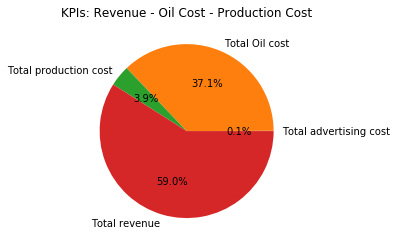

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt
def display_pie(pie_values, pie_labels, colors=None,title=''):
    plt.axis("equal")
    plt.pie(pie_values, labels=pie_labels, colors=colors, autopct="%1.1f%%")
    plt.title(title)
    plt.show()
                                                           
display_pie( [kpnv[1] for kpnv in all_kpis], [kpnv[0] for kpnv in all_kpis],title='KPIs: Revenue - Oil Cost - Production Cost')

##### Production

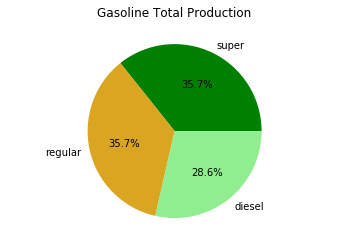

In [77]:
display_pie(total_gas_prods, gas_names, colors=["green", "goldenrod", "lightGreen"],title='Gasoline Total Production')